# Bootstrapping

The confidence intervals calculated with the uncertain fit parameters determined using ```scipy.optimize.curve_fit``` or ```lmfit.fit``` are symmetrical. We get $\pm$ some value as the standard deviation. This is a perfectly good was to estimate the confidence interval (all errors are estimated) but it hides a subtle truth. The confidence is not symmetrical. The data does not bnecesssarity have the same contribution to each parameter across the range of measuremnts and some regions may have more error than others, especially with non-linear curve fits.

One way to estimate a confidence interval that reflects these regional effects in your data series is to use bootstrapping. It is a computationally expensive method where we randomly select data points from our data set and perfomr the curve fit hundreds, perhaps thousands of times. Then we values for the parameters that encompass the 68%, 95% and 99% percentiles ($1\sigma$, $2\sigma$, $3\sigma$) or any arbitrary range we like. The median values and these upper and lower bounds will reflect a more accurate picture of estimated error, if we have enough data.

This method is not very useful with small data sets as there may not be enough combinations such that percentiles are meaningful. Choosing the 95% percentile range from 6 values is not useful. 



In [58]:
### Install and load packages
# 
# #!pip install uncertainties              # uncomment to install dependancy

from scipy.optimize import curve_fit     # tool for curve fitting
from scipy.stats import linregress     # tool for curve fitting
import scipy                             # includes tools for data analysis
import scipy.stats
import numpy as np                       # import the tools of NumPy but use a shorter name, "np"
from matplotlib import pyplot as plt     # tools for plotting
import pandas as pd

import uncertainties as un               # tool set for handling numbers with uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy that uses uncertainty values

### Set global variables

location_data = "../data/"                   ## Use either local folde or github folder. use github locations for Colab
location_styles = "../styles/"
#location_data = "https://raw.githubusercontent.com/blinkletter/StealThisCode/main/data/"
#location_styles = "https://raw.githubusercontent.com/blinkletter/StealThisCode/main/styles/"


## The Data Set

We will begin with the 5-point data set that we have been using so far and then also use the 12-point data set from the csv data file as we have also seen done in this series of eamples. First, the smaller set will be used.

In [59]:
temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

x = 1/temp
y_u = unp.log(k/temp)         # uncertain array for y-axis
y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

print(x)


def linear(x, slope, intercept):
    return slope * x + intercept

[0.00341297 0.0033557  0.00330033 0.00324675 0.00319489]


In [60]:
#import scikits.bootstrap as bs
from scipy.stats import bootstrap
from scipy.stats import linregress

m = 1; b = 1
def linear(x, m, b):
    y = m*x + b
    return y

#bootstrap(data=(x,y), statfunction = linear((x,m,b)), method = "percentile")
#bootstrap(data=(x,y), linregress((x,y)) )

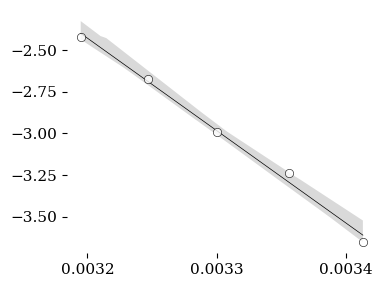

In [61]:
import seaborn as sns
plt.rcdefaults()

#x = df["1/T"]
#y = unp.nominal_values(df["ln(k)/T"])

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)


sns.regplot(x = x, y = y,
            scatter_kws = {"facecolor": "white", "edgecolor": "black", "linewidths":0.5, "zorder":5},
            line_kws = {"color": "black", "linewidth":0.5, "zorder":0}, 
            ci = 95.0, # 99% level
            )
plt.xticks([0.0032,0.0033,0.0034])
plt.show()


/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_96159/1706374144.py:54: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_samples, y_samples,


Confidence level = 68%

slope range is -5185.7 to -5843.5
median slope in bootstrap population is -5613.5 + 427.8 - 230.0
best fit value for slope is -5545.9  +/- 277.8

intercept range is 16.31 to 14.14
median intercept in bootstrap population is 15.53 + 0.78 - 1.39
best fit value for intercept is 15.31 +/- 0.92



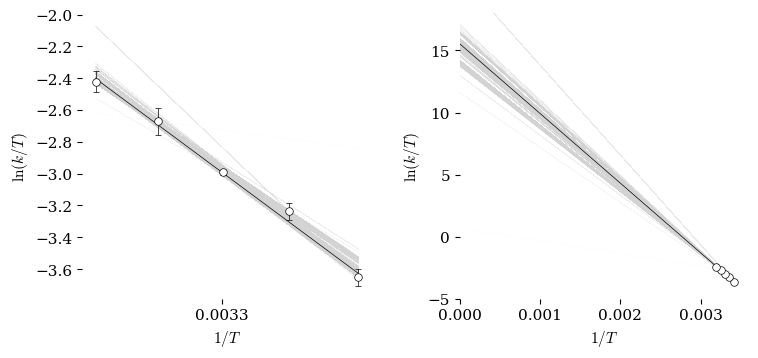

In [62]:
## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 68

#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

## Plot in range of data

slope_list = []
intercept_list = []

for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(linear, x_samples, y_samples, 
             #             sigma = y_err_samples, absolute_sigma=False  # Include st_devs for y data in calculations
                     )
    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


low_p = 50 - conf/2
high_p = 50 + conf/2

top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()


xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


In [ ]:
## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 68

#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

## Plot in range of data

slope_list = []
intercept_list = []

for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]


    popt,pcov = curve_fit(linear, x_samples, y_samples)

    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


low_p = 50 - conf/2
high_p = 50 + conf/2

top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()


xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


/var/folders/_0/pb9y62rd59n_3vs7rbl1bndm0000gn/T/ipykernel_96159/1753997735.py:70: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_samples, y_samples)


Confidence level = 95%

slope range is -4824.5 to -6036.6
median slope in bootstrap population is -5591.2 + 766.6 - 445.5
best fit value for slope is -5545.9  +/- 277.8

intercept range is 16.96 to 12.99
median intercept in bootstrap population is 15.47 + 1.49 - 2.48
best fit value for intercept is 15.31 +/- 0.92



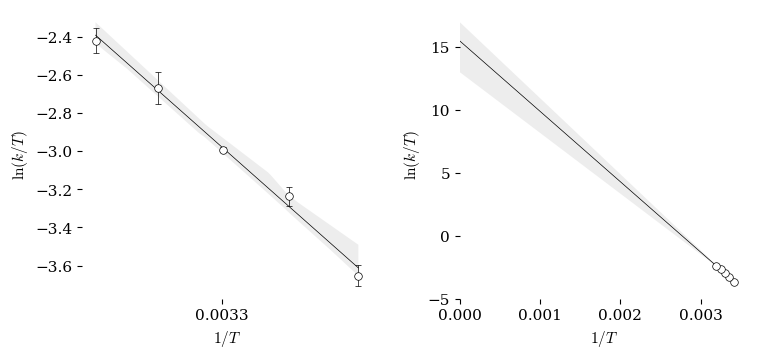

-2.3898517211383385

slope range is -2.390 to -2.492
median slope in bootstrap population is -2.464 + 0.074 - 0.028


In [85]:
################################################################################
################################################################################
################################################################################
################################################################################

## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 95

low_p = 50 - conf/2
high_p = 50 + conf/2



#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

#######################################
## Bootstrap with plots
#######################################

slope_list = []
intercept_list = []
y_list = []
x_for_ci = np.linspace(np.min(x), np.max(x), 100)
xb_for_ci = np.linspace(0, np.max(x), 100)
y_for_ci = []
yb_for_ci = []
for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(linear, x_samples, y_samples)

    y_list.append(linear(x, *popt))
    y_for_ci.append(linear(x_for_ci, *popt))
    yb_for_ci.append(linear(xb_for_ci, *popt))

    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

#    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
#    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
y_for_ci = np.array(y_for_ci)
yb_for_ci = np.array(yb_for_ci)
y_list = np.array(y_list)


#xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


#######################################
### Report
#######################################
top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()

#######################################
### Plot Best Fit
#######################################
xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x_for_ci)):
    top_y.append(np.percentile(y_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y_for_ci[:,n], low_p))
    med_y.append(np.percentile(y_for_ci[:,n], 50))

ax[0].fill_between(x_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(xb_for_ci)):
    top_y.append(np.percentile(yb_for_ci[:,n], high_p))
    bot_y.append(np.percentile(yb_for_ci[:,n], low_p))
    med_y.append(np.percentile(yb_for_ci[:,n], 50))

ax[1].fill_between(xb_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")


#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


yb_for_ci = np.array(yb_for_ci)
y_for_ci = np.array(y_for_ci)

n=5
aa = y_for_ci[:,n]
#display(aa)

top_slope = np.percentile(aa, high_p)
bot_slope = np.percentile(aa, low_p)
median_slope = np.percentile(aa, 50)

display(top_slope)

print(f"slope range is {top_slope:0.3f} to {bot_slope:0.3f}")
print(f"median slope in bootstrap population is {median_slope:0.3f} + {top_slope-median_slope:0.3f} - {median_slope-bot_slope:0.3f}")

################################################################################
################################################################################
################################################################################
################################################################################


range(0, 2000)

In [ ]:
################################################################################
################################################################################
################################################################################
################################################################################

## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 95

low_p = 50 - conf/2
high_p = 50 + conf/2



#x = np.array(df["1/T"])
#y = unp.nominal_values(df["ln(k)/T"])
#y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

#######################################
## Bootstrap with plots
#######################################

slope_list = []
intercept_list = []
y_list = []
x_for_ci = np.linspace(np.min(x), np.max(x), 100)
xb_for_ci = np.linspace(0, np.max(x), 100)
y_for_ci = []
yb_for_ci = []
for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(linear, x_samples, y_samples)

    y_list.append(linear(x, *popt))
    y_for_ci.append(linear(x_for_ci, *popt))
    yb_for_ci.append(linear(xb_for_ci, *popt))

    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

#    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
#    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
y_for_ci = np.array(y_for_ci)
yb_for_ci = np.array(yb_for_ci)
y_list = np.array(y_list)


#xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 30, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


#######################################
### Report
#######################################
top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()

#######################################
### Plot Best Fit
#######################################
xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x_for_ci)):
    top_y.append(np.percentile(y_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y_for_ci[:,n], low_p))
    med_y.append(np.percentile(y_for_ci[:,n], 50))

ax[0].fill_between(x_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(xb_for_ci)):
    top_y.append(np.percentile(yb_for_ci[:,n], high_p))
    bot_y.append(np.percentile(yb_for_ci[:,n], low_p))
    med_y.append(np.percentile(yb_for_ci[:,n], 50))

ax[1].fill_between(xb_for_ci, top_y, bot_y, 
                   facecolor="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")


#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_L.pdf")
plt.show()


yb_for_ci = np.array(yb_for_ci)
y_for_ci = np.array(y_for_ci)

n=5
aa = y_for_ci[:,n]
#display(aa)

top_slope = np.percentile(aa, high_p)
bot_slope = np.percentile(aa, low_p)
median_slope = np.percentile(aa, 50)

display(top_slope)

print(f"slope range is {top_slope:0.3f} to {bot_slope:0.3f}")
print(f"median slope in bootstrap population is {median_slope:0.3f} + {top_slope-median_slope:0.3f} - {median_slope-bot_slope:0.3f}")

################################################################################
################################################################################
################################################################################
################################################################################


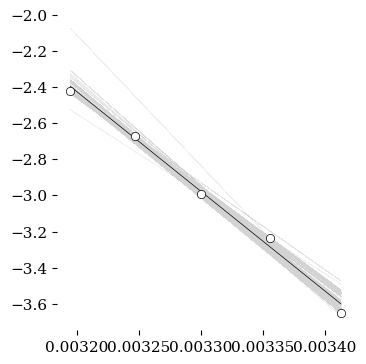

In [ ]:
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction


import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

# Create toy data 
#x = np.linspace(0, 10, 20)
#y = x + (np.random.rand(len(x)) * 10)

# Extend x data to contain another row vector of 1s
X = np.vstack([x, np.ones(len(x))]).T

n_estimators = 2000
model = BaggingRegressor(LinearRegression(), 
                         n_estimators=n_estimators,
                         bootstrap=True)

model.fit(X, y)

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

plt.figure(figsize=(4,4))

# Accessing each base_estimator (already fitted)
for m in model.estimators_:
    plt.plot(x, m.predict(X), color='lightgrey', alpha=0.01, linewidth=0.5, zorder=1)

plt.scatter(x,y, marker='o', facecolor='white', edgecolor='black', linewidths=0.5, zorder=5)

# "Bagging model" prediction
plt.plot(x, model.predict(X), color='black', linewidth=0.5, zorder=4)

plt.rcdefaults()


#size = [8,4]
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

#ax.set(
##          title = Title,       
#          ylabel=r"$\ln (k / T)$", 
#          xlabel=r"$1/T$",                
##          xlim=[0.0030,0.00354],                  
##          ylim=[-4.5,-1.1]
#       )
#plt.xticks([0.0032,0.0033,0.0034])

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bagging.pdf")
plt.show()
